# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

df = pd.read_csv('twitter-archive-enhanced.csv')
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
image_url = ['https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv']

for url in image_url:
    response = requests.get(url)

In [3]:
image_df = pd.read_csv('image-predictions.tsv', sep='\t')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
#I have chosen to use this method to query the data.

#import tweepy
#from tweepy import OAuthHandler
#import json
#from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = df.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    #for tweet_id in tweet_ids:
        #count += 1
        #print(str(count) + ": " + str(tweet_id))
        #try:
            #tweet = api.get_status(tweet_id, tweet_mode='extended')
            #print("Success")
            #json.dump(tweet._json, outfile)
            #outfile.write('\n')
        #except tweepy.TweepError as e:
            #print("Fail")
            #fails_dict[tweet_id] = e
            #pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [5]:
line_list = []

with open('tweet-json.txt', mode='r', encoding='utf-8') as data:

    lines = data.readlines()

    for line in lines:

        line_obj = json.loads(line)

        tweet_id = line_obj['id']

        retweet_count = line_obj['retweet_count']

        favorite_count = line_obj['favorite_count']

        line_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})

tweet_df = pd.DataFrame(line_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


# Assessing Data



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [81]:
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
982,749403093750648834,NaN,NaN,2016-07-03 00:43:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Duuun dun... duuun dun... dunn dun. dunn dun....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749403093...,10,10,None,None,None,None,None
244,846042936437604353,NaN,NaN,2017-03-26 16:55:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jarvis. The snow pupsets him. Officially ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/846042936...,12,10,Jarvis,None,None,None,None
1924,674075285688614912,NaN,NaN,2015-12-08 03:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mitch. He thinks that's a hat. No...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674075285...,11,10,Mitch,None,None,None,None
2292,667160273090932737,NaN,NaN,2015-11-19 01:59:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bradlay. He is a Ronaldinho Matsuyama ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667160273...,11,10,Bradlay,None,None,None,None
512,811744202451197953,NaN,NaN,2016-12-22 01:24:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Halo. She likes watermelon. 13/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/811744202...,13,10,Halo,None,None,None,None


In [8]:
df.duplicated().sum()

0

In [9]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [10]:
tweet_df.sample(10)

,tweet_id,retweet_count,favorite_count
192,855459453768019968,8987,31657
1844,675822767435051008,591,1652
249,845098359547420673,8640,0
528,808344865868283904,24069,47281
1524,690374419777196032,972,3560
753,778764940568104960,426,955
1214,714982300363173890,1166,4094
1607,685547936038666240,17465,35052
176,857393404942143489,1785,6236
1295,707776935007539200,1079,3593


In [11]:
tweet_df.duplicated().sum()

0

In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
image_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1079,717841801130979328,https://pbs.twimg.com/media/CfZJTphWAAAl5Ys.jpg,1,Brittany_spaniel,0.922876,True,English_springer,0.070113,True,bath_towel,0.002561,False
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
172,669000397445533696,https://pbs.twimg.com/media/CUjETvDVAAI8LIy.jpg,1,Pembroke,0.822940,True,Cardigan,0.177035,True,basenji,0.000023,True
576,678675843183484930,https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg,1,maze,0.339850,False,streetcar,0.099688,False,sundial,0.084808,False
848,695446424020918272,https://pbs.twimg.com/media/Caa407jWwAAJPH3.jpg,1,basenji,0.748904,True,Cardigan,0.121102,True,Pembroke,0.111767,True
297,671390180817915904,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,1,zebra,0.997673,False,tiger,0.000837,False,prairie_chicken,0.000575,False
71,667200525029539841,https://pbs.twimg.com/media/CUJfVMPXIAAgbue.jpg,1,Siberian_husky,0.694904,True,malamute,0.232006,True,Eskimo_dog,0.050635,True
1897,850380195714523136,https://pbs.twimg.com/ext_tw_video_thumb/85038...,1,Yorkshire_terrier,0.249012,True,Maltese_dog,0.166364,True,Shih-Tzu,0.142254,True
1821,834574053763584002,https://pbs.twimg.com/media/C5UAqgyXAAAbMWH.jpg,1,toilet_tissue,0.262936,False,golden_retriever,0.226564,True,bathtub,0.078879,False
1773,828011680017821696,https://pbs.twimg.com/media/C32wOLcWYAAjNqS.jpg,1,American_Staffordshire_terrier,0.936662,True,Staffordshire_bullterrier,0.032999,True,bull_mastiff,0.017183,True


In [14]:
image_df.duplicated().sum()

0

### Quality issues
1. Timestamp should be datetime, not object.


2. While the numerators are often meant to be higher than the denominator, there are some denominators higher than 10.


3. Some of the entries for dog name are not actual entries.


4. In the image dataframe, the columns p1, p2, and p3 could be renamed for clarity.


5. Dog breeds are inconsistent with capitalization and the underscores could be replaced with spaces for uniformity.


6. The in reply to, and in reply to user columns are mostly NaN, but there are a few that have very large numbers suggesting those values may not belong there.


7. Retweeted status ID and retweeted status user ID should be objects, not floats.


8. Also, retweeted timestamp should be changed from object to datetime.

### Tidiness issues
1. The columns "puppo, floofer, doggo, and pupper" could be condensed into one column named "stage of dog" as described in the dogtionary.


2. The p_1conf, p_2conf, and p_3 conf columns seem unnecessary and the tweet dateframe could be merged with the image dataframe.

## Cleaning Data

In [15]:
# Make copies of original pieces of data
df_clean = df.copy()
tweet_df_clean = tweet_df.copy()
image_df_clean = image_df.copy()

### Issue #1:

#### Define: The timestamp column will be changed to datetime instead of object.

#### Code

In [16]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
df_clean['timestamp'] = df_clean['timestamp'].astype('datetime64[ns]')

#### Test

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Issue #2:

#### Define: Change any denominators over 10 to be 10.

#### Code

In [19]:
df_clean.query("rating_denominator != '10'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [20]:
for x in df_clean.index:
    if df_clean.loc[x, 'rating_denominator'] > 10:
        df_clean.loc[x, 'rating_denominator'] = 10;
    if df_clean.loc[x, 'rating_denominator'] < 10:
        df_clean.loc[x, 'rating_denominator'] = 10

#### Test

In [21]:
df_clean.query("rating_denominator != '10'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #3:

#### Define: Iterate through dog name to find entries that are not names, and replace with NaN.  Upon testing this code, it was discovered there are other entries other than "None" that seem to be invalid if they are not uppercase.

#### Code

In [22]:
df_clean['name'].replace(['None'], value = np.nan, inplace=True)

In [23]:
is_lower = df_clean['name'].astype(str)
is_lower.str.islower().value_counts()

False    1502
True      854
Name: name, dtype: int64

In [24]:
#creating a new list with the lower case entries.  Appending an x in order to find and replace with NaN.

bad_names = []

for x in is_lower:
    if x.islower() == True:
        bad_names.append(x)
for x in bad_names:
    df_clean.replace(x, value = np.nan, inplace=True)
   

#### Test

In [25]:
df_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1594,686377065986265092,NaN,NaN,2016-01-11 02:40:19,"<a href=""http://twitter.com/download/iphone"" r...",Meet Birf. He thinks he's gone blind. 10/10 ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686377065...,10,10,Birf,None,None,pupper,None
831,768609597686943744,NaN,NaN,2016-08-25 00:43:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. His sweater is too small and he a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768609597...,10,10,Lou,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269...,10,10,NaN,None,None,None,None
1781,677698403548192770,NaN,NaN,2015-12-18 03:54:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie. She got her holidays confused. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677698403...,9,10,Sadie,None,None,None,None
1523,690607260360429569,6.903413e+17,467036706.0,2016-01-22 18:49:36,"<a href=""http://twitter.com/download/iphone"" r...",12/10 @LightningHoltt,NaN,NaN,NaN,NaN,12,10,NaN,None,None,None,None


In [26]:
df_clean['name'].isnull().value_counts()

False    1502
True      854
Name: name, dtype: int64

### Issue #4:

#### Define: In the image dataframe, the columns p1, p2, and p3 will be renamed to include "Breed" so the columns are better defined.

#### Code:

In [27]:
image_df_clean.rename(columns = {'p1':'p1_Breed', 'p2':'p2_Breed', 'p3':'p3_Breed'}, inplace=True)

#### Test

In [28]:
image_df_clean.head()

,tweet_id,jpg_url,img_num,p1_Breed,p1_conf,p1_dog,p2_Breed,p2_conf,p2_dog,p3_Breed,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #5:

#### Define: Dog breeds are inconsistent with capitalization, so each beginning letter will be replaced with a capital. Some entries have underscores which will be replaced with spaces for uniformity.

#### Code:

In [29]:
image_df_clean.head()

,tweet_id,jpg_url,img_num,p1_Breed,p1_conf,p1_dog,p2_Breed,p2_conf,p2_dog,p3_Breed,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
image_df_clean['p1_Breed'] = image_df_clean.p1_Breed.str.replace('_',' ')

In [31]:
image_df_clean['p2_Breed'] = image_df_clean.p2_Breed.str.replace('_',' ')

In [32]:
image_df_clean['p3_Breed'] = image_df_clean.p3_Breed.str.replace('_',' ')

In [33]:
image_df_clean['p1_Breed'] = image_df_clean['p1_Breed'].map(str.title)

In [34]:
image_df_clean['p2_Breed'] = image_df_clean['p2_Breed'].map(str.title)

In [35]:
image_df_clean['p3_Breed'] = image_df_clean['p3_Breed'].map(str.title)

#### Test

In [36]:
image_df_clean.head(5)

,tweet_id,jpg_url,img_num,p1_Breed,p1_conf,p1_dog,p2_Breed,p2_conf,p2_dog,p3_Breed,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #6: 

#### Define: The in reply to, and in reply to user columns are mostly NaN, but there are a few that have very large numbers suggesting those values may not belong there, so those values will be removed and replaced with NaN.

#### Code:

In [37]:
df_clean['in_reply_to_status_id'].isnull().value_counts()

True     2278
False      78
Name: in_reply_to_status_id, dtype: int64

In [38]:
df_clean['in_reply_to_user_id'].isnull().value_counts()

True     2278
False      78
Name: in_reply_to_user_id, dtype: int64

In [39]:
df_clean['in_reply_to_status_id'] = df_clean['in_reply_to_status_id'].fillna(0)

In [40]:
df_clean['in_reply_to_user_id'] = df_clean['in_reply_to_user_id'].fillna(0)

#### Test

In [41]:
df_clean['in_reply_to_status_id'].isnull().value_counts()

False    2356
Name: in_reply_to_status_id, dtype: int64

In [42]:
df_clean['in_reply_to_user_id'].isnull().value_counts()

False    2356
Name: in_reply_to_user_id, dtype: int64

### Issue #7:

#### Define: Retweeted status ID and retweeted status user ID will be converted from float to object.

#### Code:

In [43]:
df_clean['retweeted_status_id'] = df_clean['retweeted_status_id'].astype('object')
df_clean['retweeted_status_user_id'] = df_clean['retweeted_status_user_id'].astype('object')

#### Test

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null float64
in_reply_to_user_id           2356 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1502 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns]

### Issue #8:

#### Define: The retweeted status timestamp will be converted to datetime.

#### Code

In [45]:
df_clean['retweeted_status_timestamp'] = df_clean['retweeted_status_timestamp'].astype('datetime64[ns]')

#### Test

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null float64
in_reply_to_user_id           2356 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1502 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: dateti

## Tidiness

#### Define: The puppo, doggo, floofer, and pupper columns will be removed and one column created for the respective entries.

#### Code:

In [47]:
df_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,0.0,0.0,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,0.0,0.0,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,0.0,0.0,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,0.0,0.0,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,0.0,0.0,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Creating new df's with each stage of dog column of data and append together.

In [48]:
doggo = df_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
                 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
                 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo']]
floofer = df_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
                 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
                 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'floofer']]
pupper = df_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
                 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
                 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'pupper']]
puppo = df_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
                 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
                 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'puppo']]


In [49]:
doggo = doggo.rename(columns={'doggo':'stage_of_dog'});
floofer = floofer.rename(columns={'floofer':'stage_of_dog'});
pupper = pupper.rename(columns={'pupper':'stage_of_dog'});
puppo = puppo.rename(columns={'puppo':'stage_of_dog'});

In [50]:
doggo = doggo.append(floofer, ignore_index=True, sort=False)
doggo = doggo.append(pupper, ignore_index=True, sort=False)
doggo = doggo.append(puppo, ignore_index=True, sort=False)
doggo.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage_of_dog
0,892420643555336193,0.0,0.0,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,0.0,0.0,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,0.0,0.0,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,0.0,0.0,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,0.0,0.0,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None


In [51]:
df_clean = doggo.drop_duplicates()

In [52]:
df_clean.duplicated().sum()

0

In [53]:
doggo['stage_of_dog'].value_counts()

None       9030
pupper      257
doggo        97
puppo        30
floofer      10
Name: stage_of_dog, dtype: int64

#### Define: The p_1conf, p_2conf, and p_3conf columns will be removed and the tweet dataframe will be merged on "tweet_id" to create one table.

In [58]:
df_clean.count()

tweet_id                      2750
in_reply_to_status_id         2750
in_reply_to_user_id           2750
timestamp                     2750
source                        2750
text                          2750
retweeted_status_id            219
retweeted_status_user_id       219
retweeted_status_timestamp     219
expanded_urls                 2685
rating_numerator              2750
rating_denominator            2750
name                          1710
stage_of_dog                  2750
dtype: int64

#### Code:

In [60]:
df_clean = df_clean.merge(image_df_clean,how ='left').merge(tweet_df_clean,how ='left')

In [82]:
df_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage_of_dog,jpg_url,img_num,p1_Breed,p2_Breed,p3_Breed,retweet_count,favorite_count
1525,690400367696297985,0.0,0.0,2016-01-22 05:07:29,"<a href=""http://twitter.com/download/iphone"" r...",This is Eriq. His friend just reminded him of ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/690400367...,...,10,Eriq,None,https://pbs.twimg.com/media/CZTLeBuWIAAFkeR.jpg,1.0,Pembroke,Papillon,Shetland Sheepdog,509.0,2041.0
1996,672591762242805761,0.0,0.0,2015-12-04 01:42:26,"<a href=""http://twitter.com/download/iphone"" r...",This is Taz. He boxes leaves. 10/10 https://t....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/672591762...,...,10,Taz,None,https://pbs.twimg.com/media/CVWGotpXAAMRfGq.jpg,1.0,Kuvasz,Great Pyrenees,Golden Retriever,367.0,1014.0
74,878316110768087041,0.0,0.0,2017-06-23 18:17:33,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.69e+17,4.19698e+09,2015-11-24 03:51:38,https://twitter.com/dog_rates/status/669000397...,...,10,Terrance,None,NaN,NaN,NaN,NaN,NaN,6965.0,0.0
824,769940425801170949,0.0,0.0,2016-08-28 16:51:16,"<a href=""http://twitter.com/download/iphone"" r...",This is Klein. These pics were taken a month a...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/769940425...,...,10,Klein,None,https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg,1.0,Miniature Pinscher,Chihuahua,Staffordshire Bullterrier,11131.0,34948.0
1691,681320187870711809,0.0,0.0,2015-12-28 03:46:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Glacier. He's a very happy pup. Loves ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/681320187...,...,10,Glacier,None,https://pbs.twimg.com/media/CXSJGAQUQAAoG9Q.jpg,1.0,Samoyed,Eskimo Dog,Siberian Husky,863.0,2918.0


In [62]:
df_clean = df_clean.drop(['p1_conf', 'p1_dog', 'p2_conf', 'p2_dog', 'p3_conf', 'p3_dog'], axis=1)


#### Test

In [63]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage_of_dog,jpg_url,img_num,p1_Breed,p2_Breed,p3_Breed,retweet_count,favorite_count
0,892420643555336193,0.0,0.0,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,Bagel,Banana,8853.0,39467.0
1,892177421306343426,0.0,0.0,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,Pekinese,Papillon,6514.0,33819.0
2,891815181378084864,0.0,0.0,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,Malamute,Kelpie,4328.0,25461.0
3,891689557279858688,0.0,0.0,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper Towel,Labrador Retriever,Spatula,8964.0,42908.0
4,891327558926688256,0.0,0.0,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,English Springer,German Short-Haired Pointer,9774.0,41048.0


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [64]:
df_clean.to_csv('twitter_archive_master.csv', index = False)

df1 = pd.read_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [83]:
df1.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage_of_dog,jpg_url,img_num,p1_Breed,p2_Breed,p3_Breed,retweet_count,favorite_count
1293,708026248782585858,0.000000e+00,0.000000e+00,2016-03-10 20:26:26,"<a href=""http://twitter.com/download/iphone"" r...",Everybody stop what you're doing and watch thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708026248...,...,10,NaN,None,https://pbs.twimg.com/ext_tw_video_thumb/70802...,1.0,Malinois,Chesapeake Bay Retriever,Siamese Cat,2166.0,4799.0
838,767500508068192258,0.000000e+00,0.000000e+00,2016-08-21 23:15:55,"<a href=""http://twitter.com/download/iphone"" r...",This is Louie. He's making quite a h*ckin mess...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/767500508...,...,10,Louie,None,https://pbs.twimg.com/media/Cqa1ofnXEAAG0yn.jpg,1.0,Chow,Golden Retriever,Norfolk Terrier,2688.0,8295.0
122,869227993411051520,0.000000e+00,0.000000e+00,2017-05-29 16:24:37,"<a href=""http://twitter.com/download/iphone"" r...",This is Gizmo. His favorite thing is standing ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/869227993...,...,10,Gizmo,None,https://pbs.twimg.com/media/DBAePiVXcAAqHSR.jpg,1.0,Pembroke,Chihuahua,Cardigan,4023.0,21112.0
286,838831947270979586,0.000000e+00,0.000000e+00,2017-03-06 19:21:35,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Riley. His owner put a ...,7.838400e+17,4.196984e+09,2016-10-06 01:23:05,https://twitter.com/dog_rates/status/783839966...,...,10,Riley,None,NaN,NaN,NaN,NaN,NaN,12643.0,0.0
1106,734787690684657664,0.000000e+00,0.000000e+00,2016-05-23 16:46:51,"<a href=""http://twitter.com/download/iphone"" r...",This dog is more successful than I will ever b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734787690...,...,10,NaN,None,https://pbs.twimg.com/media/CjJ9gQ1WgAAXQtJ.jpg,4.0,Golden Retriever,Chow,Labrador Retriever,7102.0,13745.0
2279,667405339315146752,0.000000e+00,0.000000e+00,2015-11-19 18:13:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Biden. Biden just tripped... 7/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667405339...,...,10,Biden,None,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,1.0,Saint Bernard,Leonberg,Golden Retriever,234.0,489.0
826,769335591808995329,0.000000e+00,0.000000e+00,2016-08-27 00:47:53,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Ever seen a dog pet another dog...,7.069045e+17,4.196984e+09,2016-03-07 18:09:06,"https://vine.co/v/iXQAm5Lrgrh,https://vine.co/...",...,10,NaN,None,NaN,NaN,NaN,NaN,NaN,8830.0,0.0
840,767122157629476866,0.000000e+00,0.000000e+00,2016-08-20 22:12:29,"<a href=""http://twitter.com/download/iphone"" r...",This is Rupert. You betrayed him with bath tim...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/767122157...,...,10,Rupert,None,https://pbs.twimg.com/media/CqVdiBJWIAEDZB4.jpg,2.0,Toy Poodle,Miniature Poodle,Irish Terrier,3261.0,11227.0
1621,684926975086034944,0.000000e+00,0.000000e+00,2016-01-07 02:38:10,"<a href=""http://twitter.com/download/iphone"" r...",Meet Bruiser &amp; Charlie. They are the best ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684926975...,...,10,Bruiser,None,https://pbs.twimg.com/media/CYFZXdiU0AAc_kw.jpg,1.0,Labrador Retriever,Golden Retriever,Lion,552.0,3849.0
1127,729838605770891264,7.291135e+17,4.196984e+09,2016-05-10 01:00:58,"<a href=""http://twitter.com/download/iphone"" r...","""Challenge completed"" \n(pupgraded to 12/10) h...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/729838605...,...,10,NaN,None,https://pbs.twimg.com/ext_tw_video_thumb/72983...,1.0,Stone Wall,Patio,Prison,431.0,1856.0


#### 1. Which dog name is the most popular?

In [84]:
df1.name.value_counts()

Charlie       12
Oliver        11
Cooper        11
Lucy          11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
Daisy          7
Bailey         7
Buddy          7
Toby           7
Bella          6
Scout          6
Rusty          6
Jack           6
Koda           6
Dave           6
Leo            6
Oscar          6
Milo           6
Jax            6
Stanley        6
Phil           5
Alfie          5
Sunny          5
Bentley        5
Larry          5
              ..
Zuzu           1
Huxley         1
Iroh           1
Jessiga        1
Julius         1
Edd            1
Combo          1
Hall           1
Grady          1
Crumpet        1
Banditt        1
Diogi          1
Craig          1
Brownie        1
Alexander      1
Chevy          1
Rose           1
Rolf           1
Tiger          1
Binky          1
Jiminus        1
Travis         1
Harry          1
Mosby          1
Christoper     1
Kallie         1
Wishes         1
Bert          

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 21 columns):
tweet_id                      2750 non-null int64
in_reply_to_status_id         2750 non-null float64
in_reply_to_user_id           2750 non-null float64
timestamp                     2750 non-null object
source                        2750 non-null object
text                          2750 non-null object
retweeted_status_id           219 non-null float64
retweeted_status_user_id      219 non-null float64
retweeted_status_timestamp    219 non-null object
expanded_urls                 2685 non-null object
rating_numerator              2750 non-null int64
rating_denominator            2750 non-null int64
name                          1710 non-null object
stage_of_dog                  2750 non-null object
jpg_url                       2409 non-null object
img_num                       2409 non-null float64
p1_Breed                      2409 non-null object
p2_Breed                   

### Insights:
1. Which dog name is the most popular?

2. Which dog breed had the highest retweet count?

3. Which submission to We Rate Dogs had the highest favorite count and does it correlate with the breed with the most retweets?

#### 2. Which breed had the highest retweet count?

In [68]:
breed_retweets = df1.groupby('p1_Breed')['retweet_count'].sum().sort_values(ascending = False).head(10)
breed_retweets

p1_Breed
Golden Retriever      788148.0
Labrador Retriever    551512.0
Chihuahua             345090.0
Pembroke              336930.0
Samoyed               258361.0
Standard Poodle       173107.0
French Bulldog        158691.0
Eskimo Dog            145876.0
Pomeranian            137705.0
Chow                  137191.0
Name: retweet_count, dtype: float64

#### *When executing this code, it was discovered that there were entries with duplicated tweet id's.  The duplicated values were dropped, keeping only one entry.

In [77]:
df1 = df1.drop_duplicates(subset='tweet_id', keep="last")

In [78]:
df1.duplicated('tweet_id').sum()

0

#### 3. Which submission has the highest favorite count, and does it correlate with the breed with the highest retweet count?

In [80]:
favorite = df1.query('favorite_count == favorite_count.max()')
favorite

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage_of_dog,jpg_url,img_num,p1_Breed,p2_Breed,p3_Breed,retweet_count,favorite_count
2730,822872901745569793,0.0,0.0,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822872901...,...,10,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.0,Lakeland Terrier,Labrador Retriever,Irish Terrier,48265.0,132810.0


#### The tweet with the highest favorite count is a Lakeland Terrier, which is not the same as the breed with the most retweets, the Golden Retriever.

### Visualization

### What is the ratio of dog stages?

In [74]:
df1['stage_of_dog'].value_counts()

None       2060
pupper      257
puppo        30
floofer       9
Name: stage_of_dog, dtype: int64

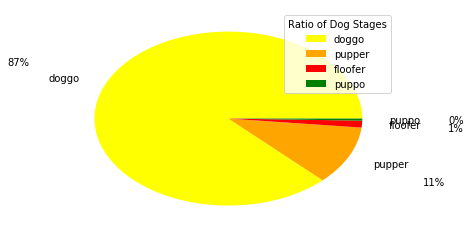

In [75]:
labels = ['doggo', 'pupper', 'floofer', 'puppo']
values = df1.stage_of_dog.value_counts(normalize=True)
colors = ['yellow', 'orange', 'red', 'green']

plt.pie(values, colors=colors, labels=labels, autopct='%1.0f%%', labeldistance=1.2, pctdistance=1.7)
plt.legend(labels, title = "Ratio of Dog Stages");